## Import your stuff

In [ ]:
pip install git+https://github.com/tomcharnock/probability.git@conditionalmaf

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from pydelfi import delfi

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
from simulators.jla_supernovae import jla_simulator as jla

JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/charnock/Physics/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5]).astype(np.float32)
upper = np.array([0.6, 0, -18, 1, 6, 0.5]).astype(np.float32)
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(lower.shape[0])])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
from pydelfi import score
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

We can now use any tfp.distribution, for example a MAF. Note that we need the distribution to be conditional on the parameters, i.e. 3 MAFs can be made like

```python
tfb = tfp.bijectors
NDEs = [tfd.TransformedDistribution(
            distribution=tfd.Normal(loc=0., scale=1.),
            bijector=tfb.MaskedAutoregressiveFlow(
                shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
                    params=2, 
                    hidden_units=[50, 50], 
                    activation=tf.keras.layers.LeakyReLU,
                    event_shape=[6],
                    conditional=True,
                    conditional_shape=[6],
                    conditional_input_all_layers=True)),
            event_shape=[6]) 
        for i in range(3)]
```

Note for convenience, the pydelfi.ndes module has a wrapper

```python
from pydelfi import ndes
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6, 
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01), 
            all_layers=True)
        for i in range(3)]
```
There is an example of how to construct a mixture density network in `ndes` too, which can be called using 
```python
from pydelfi import ndes
NDEs = [ndes.MixtureDensityNetwork(
            n_parameters=6,
            n_data=6, 
            n_components=3,
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(3)]
```

We will use a mixture of 3 MAFs and 3 MDNs

In [6]:
from pydelfi import ndes
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6, 
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01), 
            all_layers=True)
        for i in range(3)]
NDEs += [ndes.MixtureDensityNetwork(
            n_parameters=6,
            n_data=6, 
            n_components=3,
            n_hidden=[50,50], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(3)]

## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv=Finv, 
                            theta_fiducial=theta_fiducial, 
                            param_names=['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir="simulators/jla_supernovae/results",
                            filename="jla",
                            optimiser=tf.keras.optimizers.Adam,
                            optimiser_arguments=None,
                            dtype=tf.float32)

## Fisher pre-training to initialize the NDEs

Training terminated for model 5 at epoch 43.
Training terminated for model 3 at epoch 66.
Training terminated for model 4 at epoch 66.
Training terminated for model 0 at epoch 219.
Sampling approximate posterior...
Done.
Removed no burn in


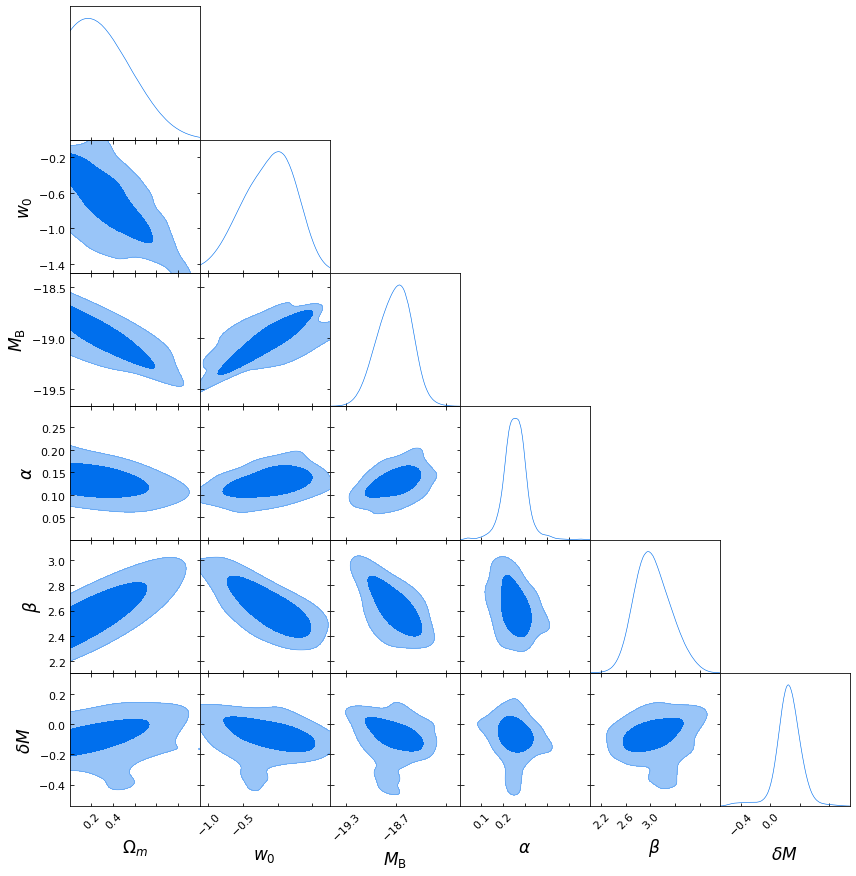

In [8]:
DelfiEnsemble.fisher_pretraining(epochs=250, patience=20, plot=True)

## Sequential Neural Likelihood

Training terminated for model 3 at epoch 25.


W0323 10:27:47.502159 4543413696 def_function.py:586] 5 out of the last 10 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 39.


W0323 10:28:09.826854 4543413696 def_function.py:586] 6 out of the last 12 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 48.


W0323 10:29:53.365397 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 1 at epoch 155.


W0323 10:30:06.840383 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 0 at epoch 176.
Training terminated for model 2 at epoch 232.
Sampling approximate posterior...


W0323 10:30:45.508742 4543413696 mcsamples.py:497] outlier fraction 0.00020742584526031943 


Done.
Removed no burn in


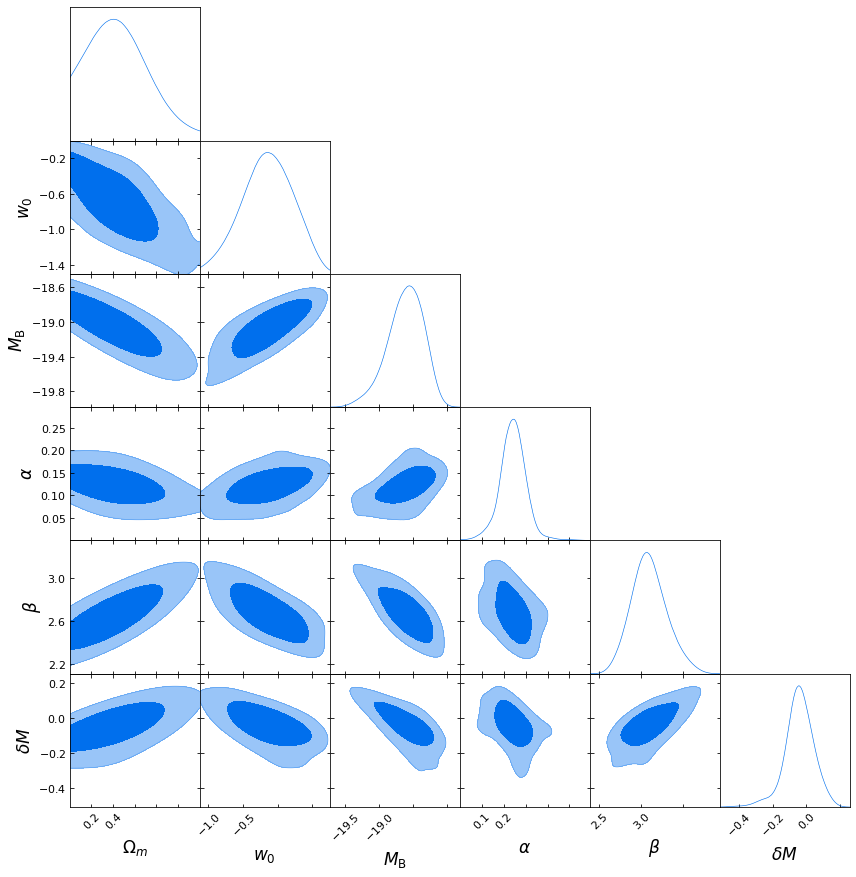

Population 1/10
Sampling proposal density...
Done.


Training terminated for model 1 at epoch 21.


W0323 10:32:08.699826 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 35.


W0323 10:32:28.354506 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 61.


W0323 10:32:57.905544 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 3 at epoch 88.


W0323 10:33:24.432397 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 2 at epoch 93.
Training terminated for model 0 at epoch 104.
Sampling approximate posterior...
Done.
Removed no burn in


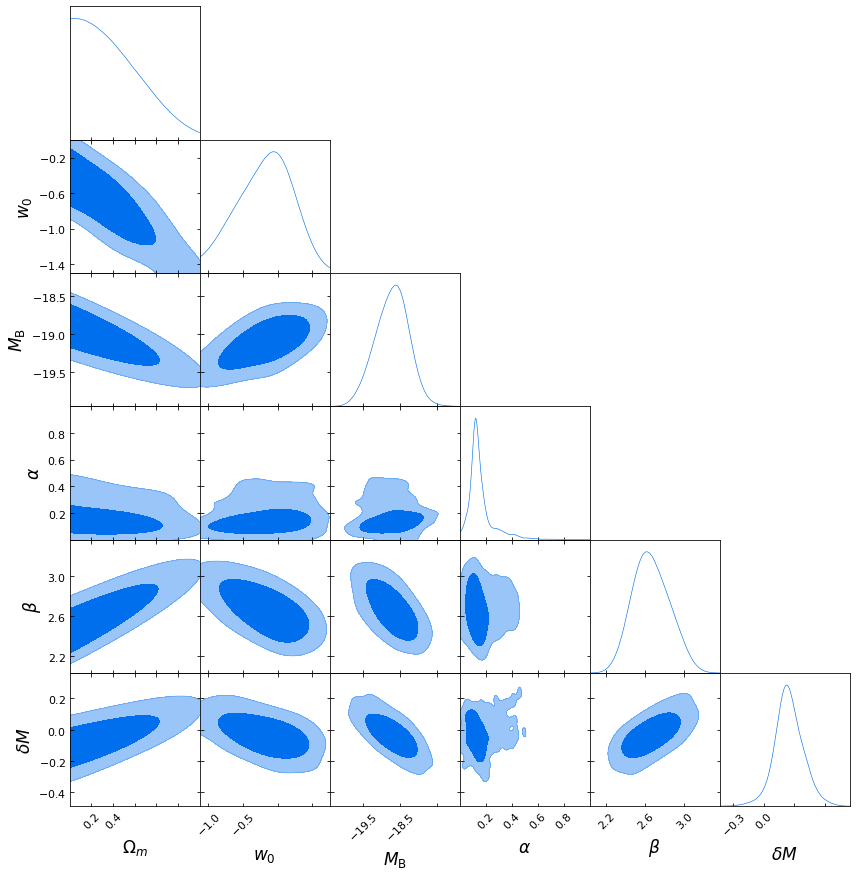

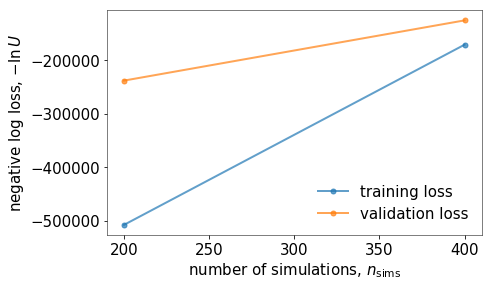

Population 2/10
Sampling proposal density...
Done.


Training terminated for model 2 at epoch 28.


W0323 10:35:23.391880 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 41.


W0323 10:35:43.058264 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 0 at epoch 42.


W0323 10:35:45.623967 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 1 at epoch 53.


W0323 10:35:55.918586 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W0323 10:36:06.510316 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to http

Training terminated for model 4 at epoch 71.
Training terminated for model 3 at epoch 194.
Sampling approximate posterior...


W0323 10:37:04.383882 4543413696 mcsamples.py:497] outlier fraction 0.00021190930281839374 


Done.
Removed no burn in


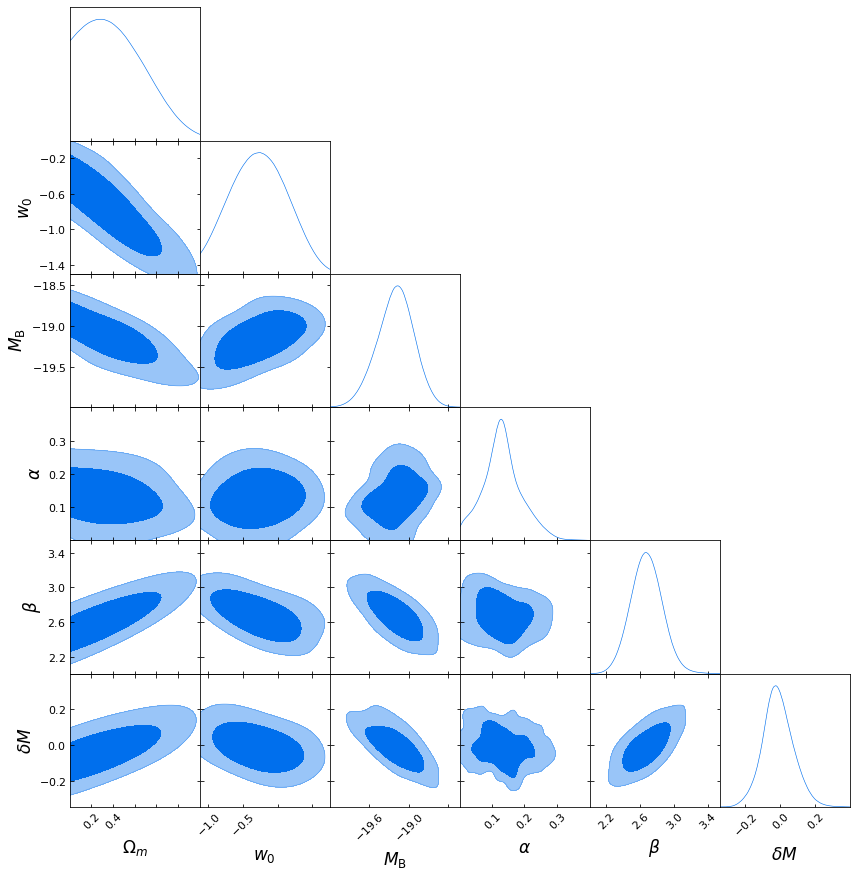

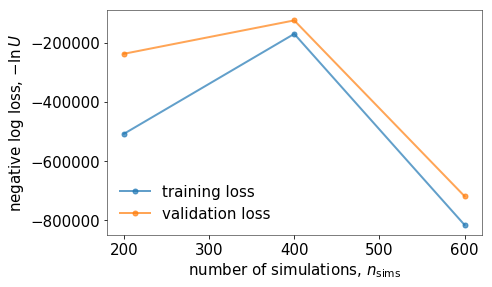

Population 3/10
Sampling proposal density...
Done.


Training terminated for model 3 at epoch 27.
Training terminated for model 5 at epoch 32.


W0323 10:38:51.992378 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 0 at epoch 37.


W0323 10:38:59.092159 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 45.
Training terminated for model 1 at epoch 58.
Training terminated for model 2 at epoch 122.
Sampling approximate posterior...
Done.
Removed no burn in


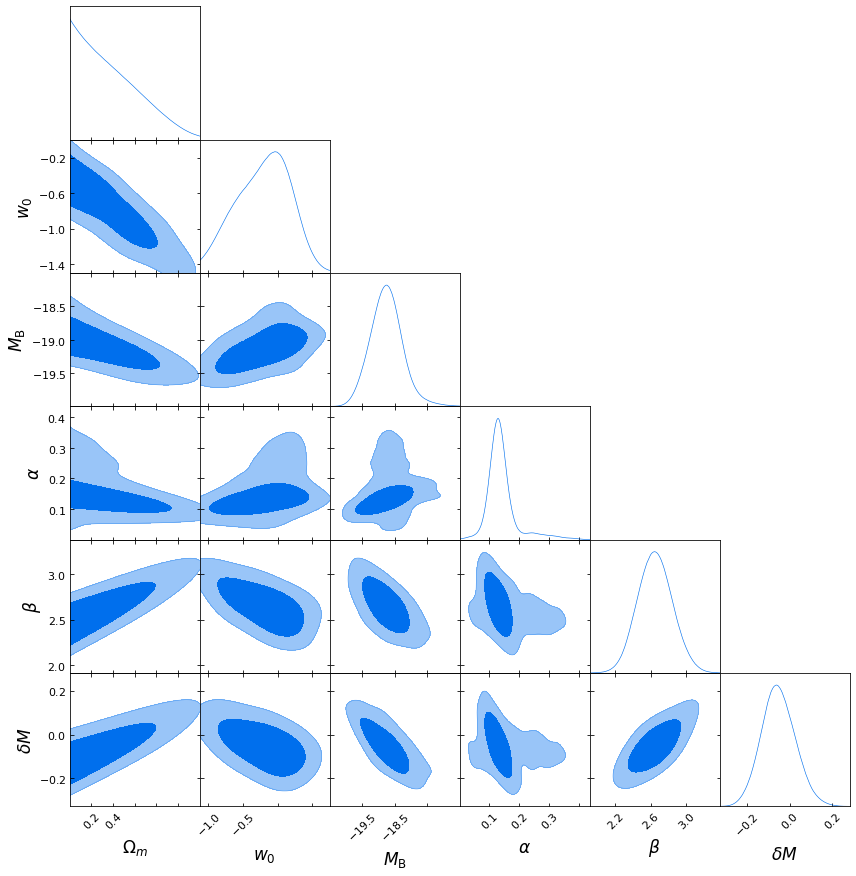

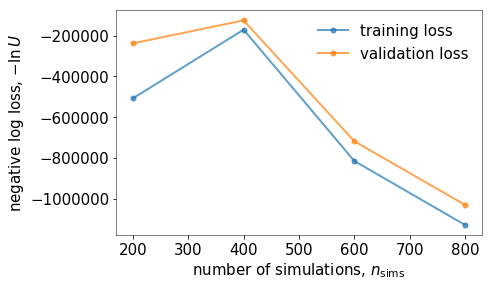

Population 4/10
Sampling proposal density...
Done.


Training terminated for model 2 at epoch 33.
Training terminated for model 1 at epoch 38.


W0323 10:41:49.161272 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 50.


W0323 10:42:03.982053 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 0 at epoch 51.


W0323 10:42:05.999135 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W0323 10:42:22.283904 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to http

Training terminated for model 3 at epoch 78.
Training terminated for model 5 at epoch 85.
Sampling approximate posterior...
Done.
Removed no burn in


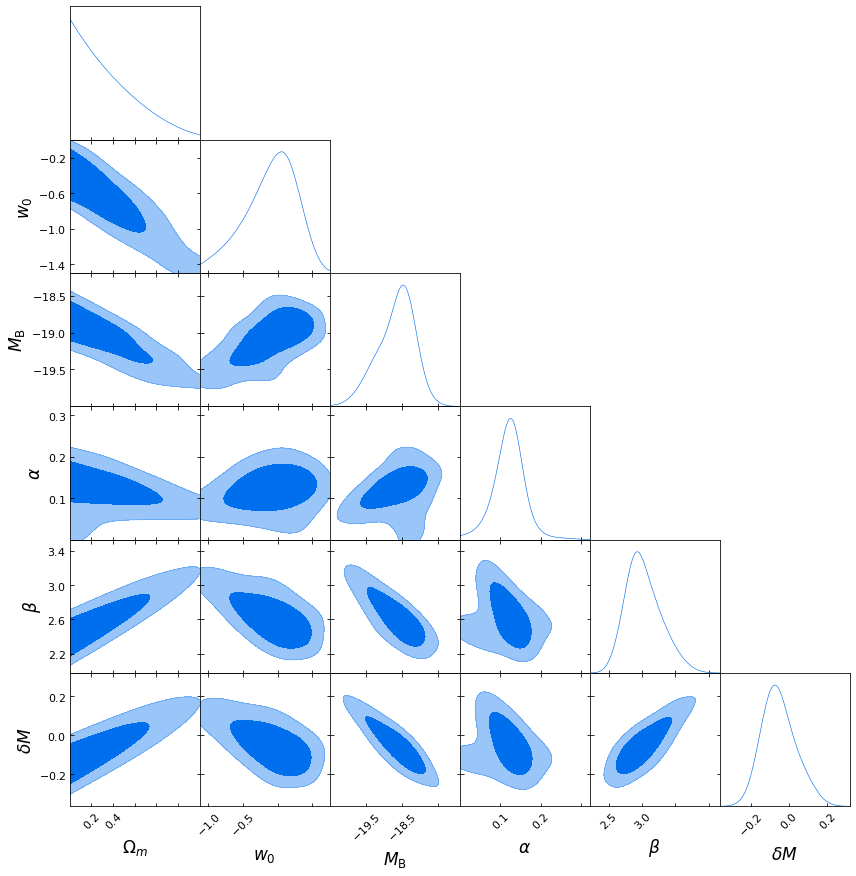

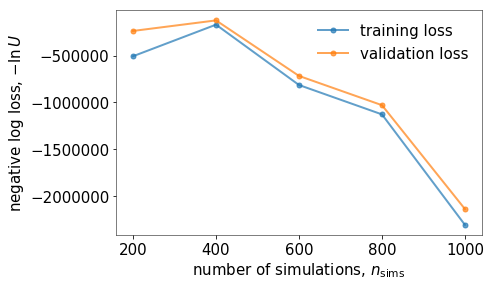

Population 5/10
Sampling proposal density...
Done.


Training terminated for model 1 at epoch 21.
Training terminated for model 3 at epoch 40.


W0323 10:44:34.238708 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 41.


W0323 10:44:36.937453 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 2 at epoch 47.


W0323 10:44:43.215809 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 75.
Training terminated for model 0 at epoch 84.
Sampling approximate posterior...


W0323 10:45:23.459558 4543413696 mcsamples.py:497] outlier fraction 0.00021616947686986597 


Done.
Removed no burn in


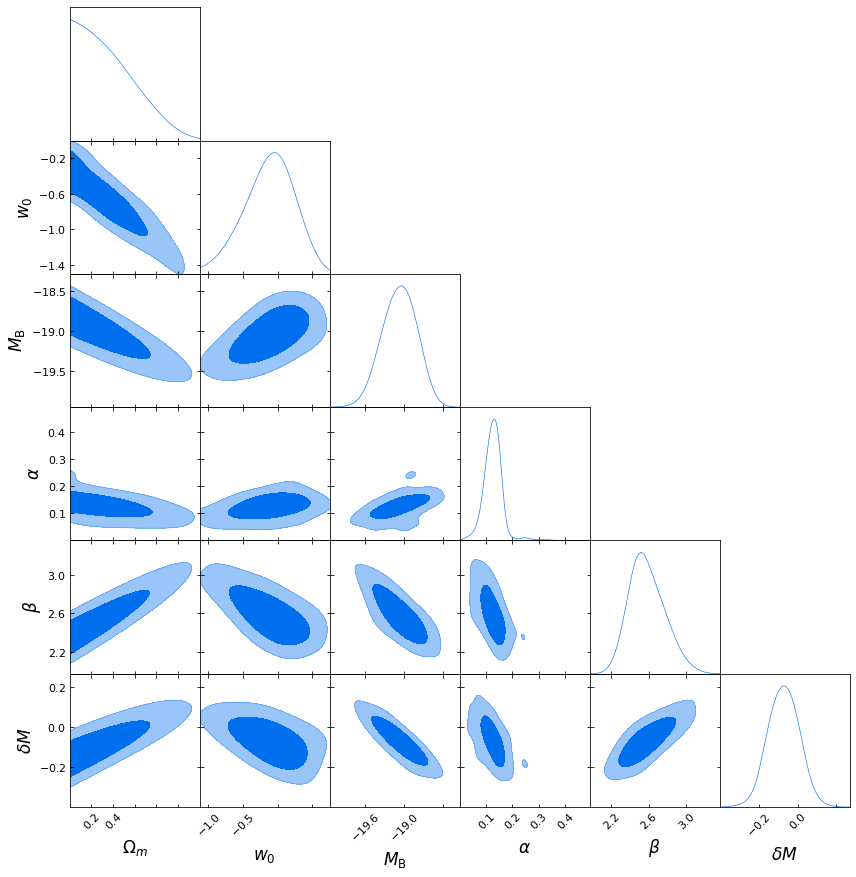

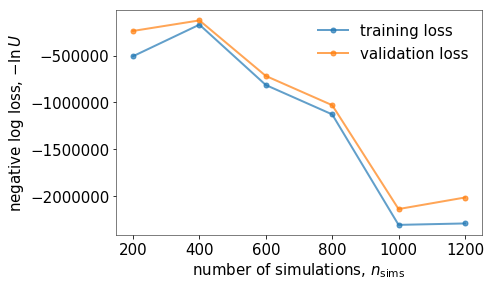

Population 6/10
Sampling proposal density...
Done.


Training terminated for model 5 at epoch 23.
Training terminated for model 3 at epoch 26.
Training terminated for model 0 at epoch 36.
Training terminated for model 4 at epoch 38.
Training terminated for model 1 at epoch 55.
Training terminated for model 2 at epoch 57.
Sampling approximate posterior...


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
W0323 10:47:46.109285 4543413696 mcsamples.py:497] outlier fraction 0.00021074815595363542 


Done.
Removed no burn in


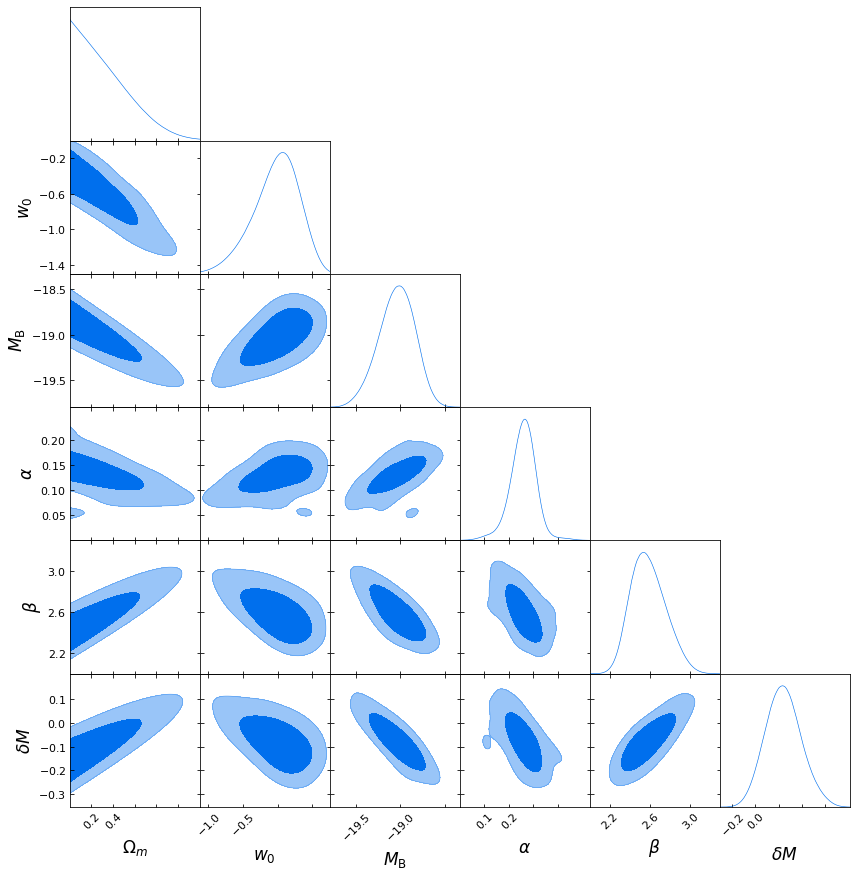

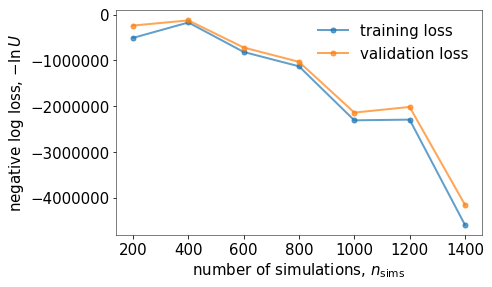

Population 7/10
Sampling proposal density...


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


Training terminated for model 2 at epoch 23.
Training terminated for model 0 at epoch 24.


W0323 10:49:15.763864 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 37.


W0323 10:49:31.667289 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 1 at epoch 41.
Training terminated for model 5 at epoch 41.
Training terminated for model 3 at epoch 47.
Sampling approximate posterior...
Done.
Removed no burn in


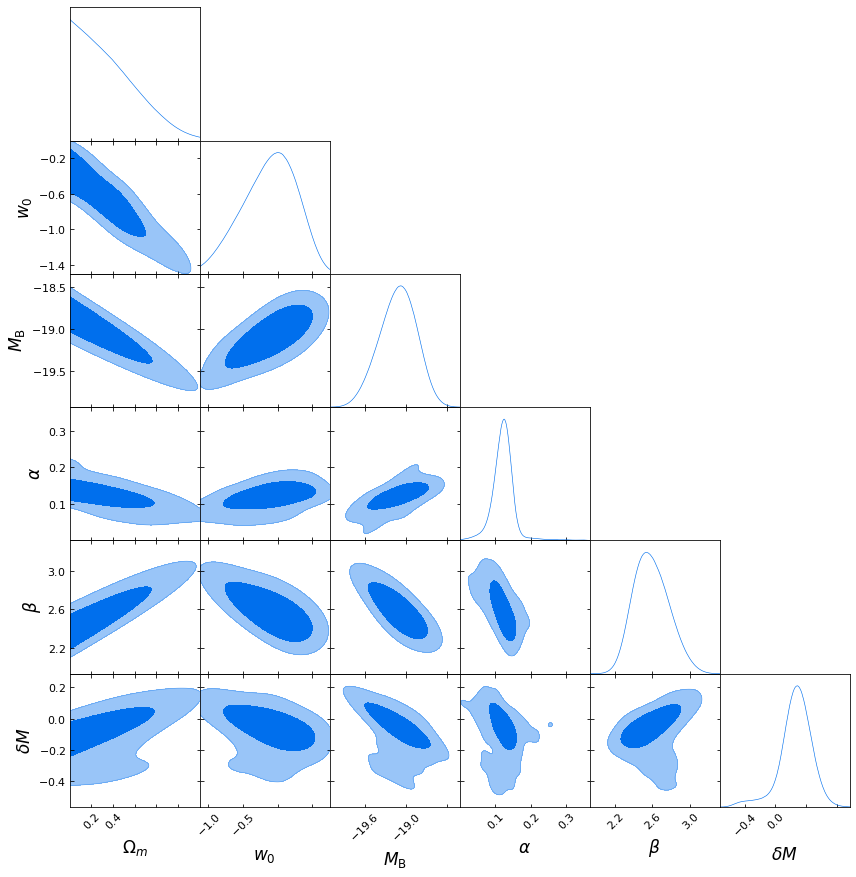

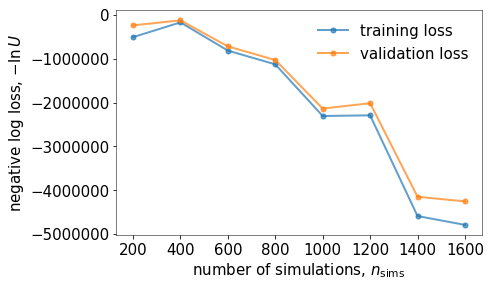

Population 8/10
Sampling proposal density...
Done.


Training terminated for model 5 at epoch 25.
Training terminated for model 0 at epoch 27.


W0323 10:51:32.857690 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 4 at epoch 41.


W0323 10:51:51.207040 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 1 at epoch 42.


W0323 10:51:53.300873 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 2 at epoch 48.
Training terminated for model 3 at epoch 51.
Sampling approximate posterior...


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
W0323 10:52:19.542778 4543413696 mcsamples.py:497] outlier fraction 0.00022306491188935982 


Done.
Removed no burn in


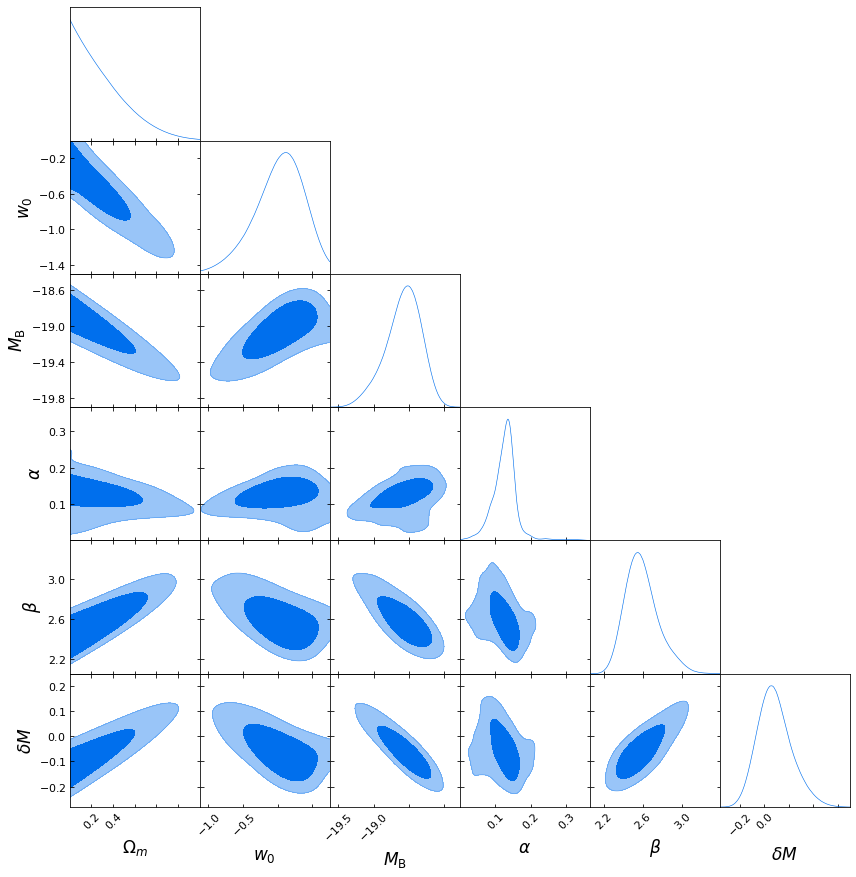

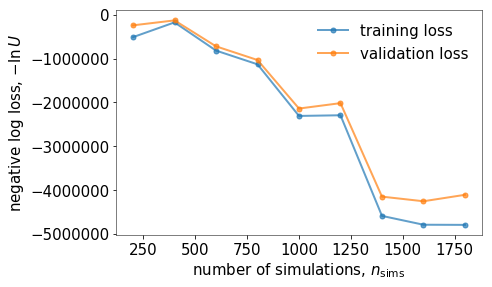

Population 9/10
Sampling proposal density...
Done.


Training terminated for model 1 at epoch 22.
Training terminated for model 3 at epoch 27.
Training terminated for model 0 at epoch 33.


W0323 10:53:58.980700 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 2 at epoch 51.


W0323 10:54:14.153641 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
W0323 10:54:17.624643 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to http

Training terminated for model 5 at epoch 56.
Training terminated for model 4 at epoch 79.
Sampling approximate posterior...


W0323 10:54:45.648665 4543413696 mcsamples.py:497] outlier fraction 0.000450755014649538 


Done.
Removed no burn in


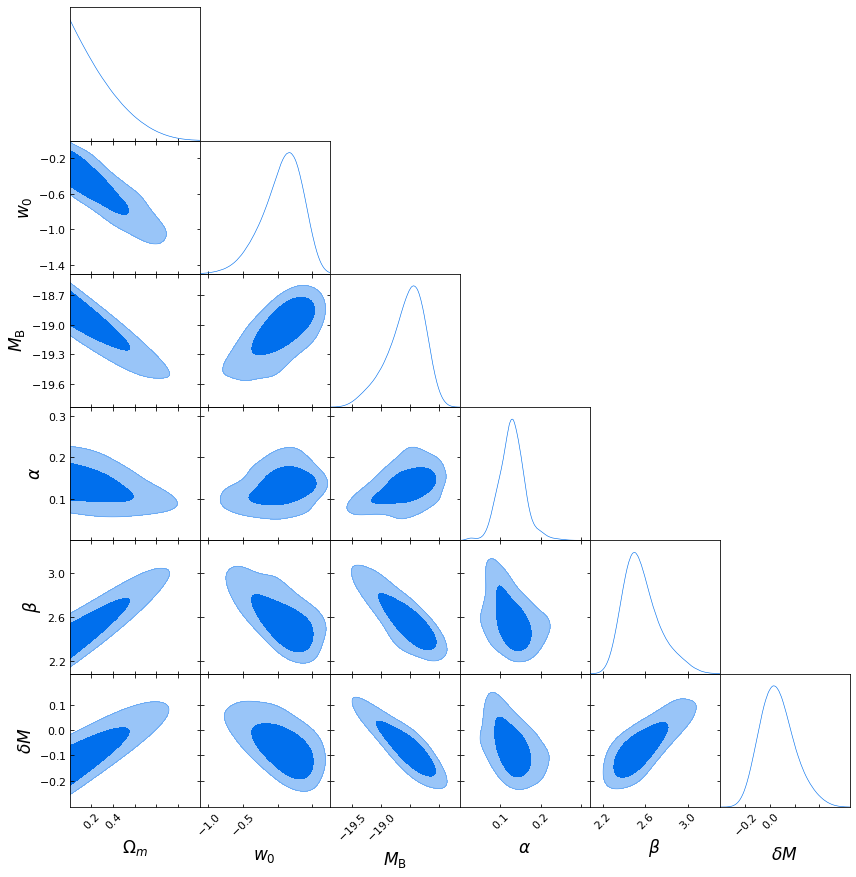

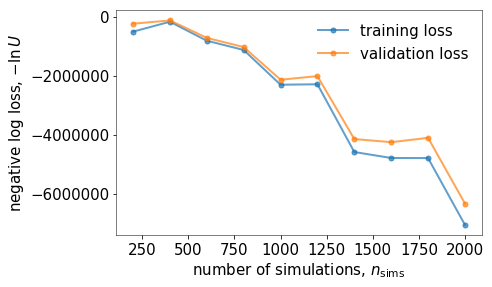

Population 10/10
Sampling proposal density...
Done.


Training terminated for model 1 at epoch 24.
Training terminated for model 3 at epoch 24.
Training terminated for model 4 at epoch 32.
Training terminated for model 0 at epoch 34.


W0323 10:56:28.142094 4543413696 def_function.py:586] 6 out of the last 11 calls to <function NDE.log_prob at 0x13a734b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


Training terminated for model 5 at epoch 44.
Training terminated for model 2 at epoch 67.
Sampling approximate posterior...


W0323 10:57:02.785557 4543413696 mcsamples.py:497] outlier fraction 0.00021399529210357372 


Done.
Removed no burn in


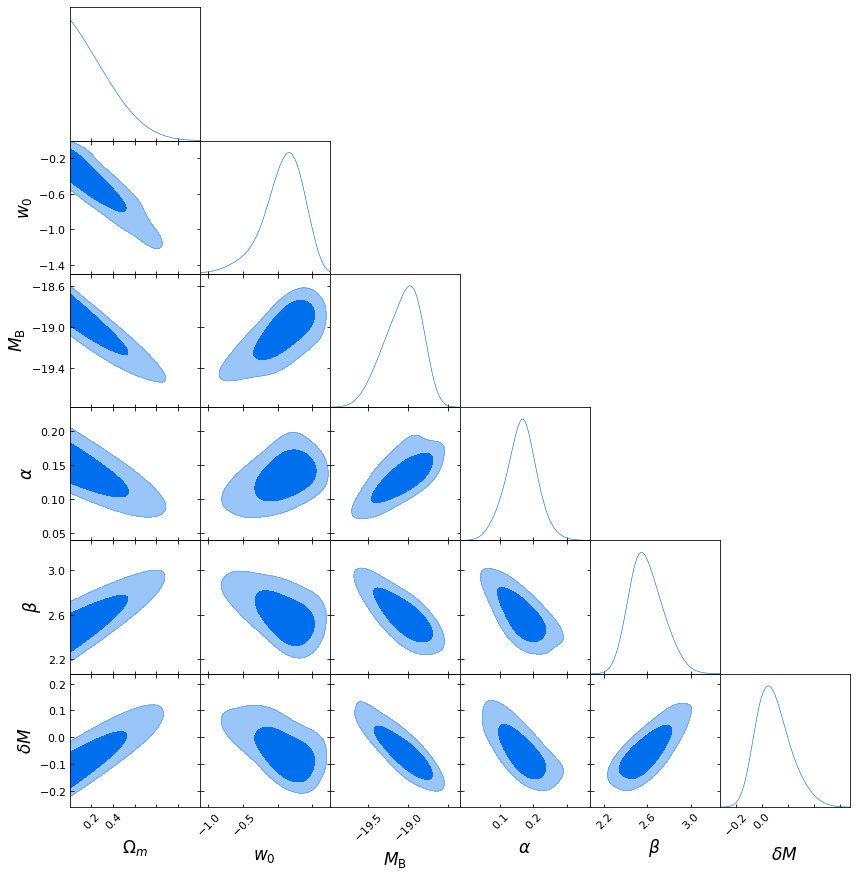

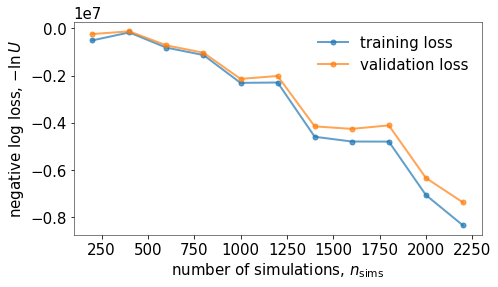

In [9]:
n_initial = 200
n_batch = 200
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, plot=True, save_intermediate_posteriors=True)

## Sample the learned posterior

In [17]:
posterior_samples, posterior_weights, log_posterior_values = DelfiEnsemble.emcee_sample()

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


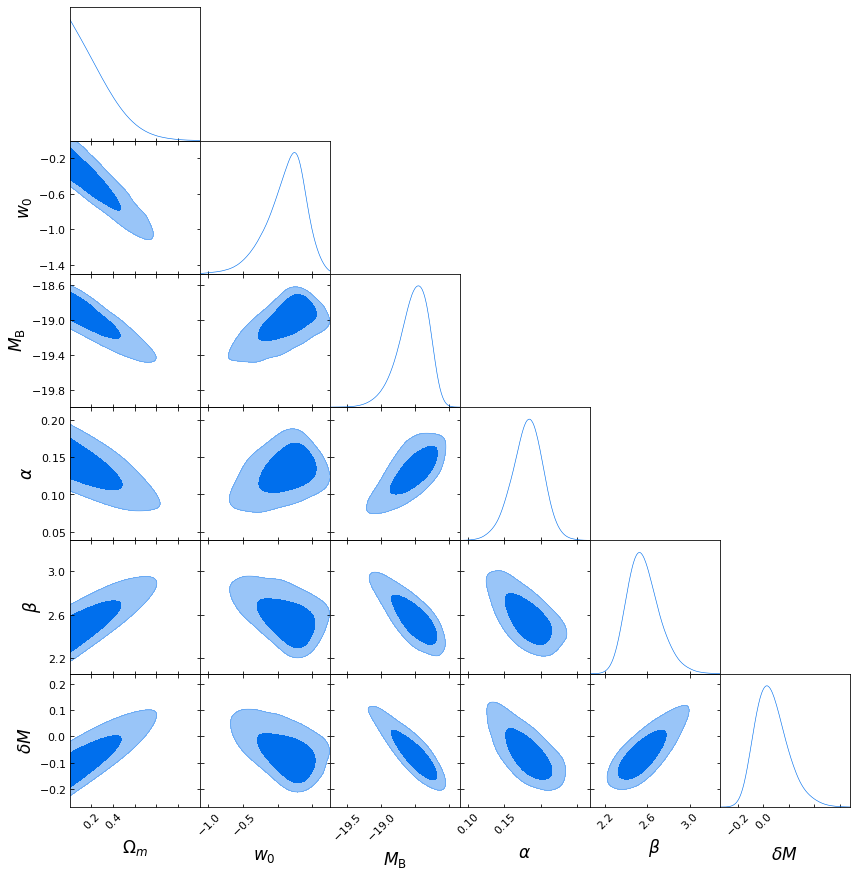

In [18]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])